In [24]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Télécharger les données
data = yf.download("AAPL", start="2020-01-01", end="2024-01-01")



C:\Users\tutup\AppData\Local\Temp\ipykernel_17616\2188024609.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2020-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


In [25]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.468277,72.528597,71.223274,71.476615,135480400
2020-01-03,71.763725,72.523754,71.539337,71.696167,146322800
2020-01-06,72.335548,72.374154,70.634532,70.885464,118387200
2020-01-07,71.995354,72.600960,71.775789,72.345204,108872000
2020-01-08,73.153496,73.455095,71.698581,71.698581,132079200


In [26]:
#création des features 

#returns(variations du prix)
data["return_1d"] = data["Close"].pct_change()
data["return_5d"] = data["Close"].pct_change(5)
data["return_20d"] = data["Close"].pct_change(20)


In [27]:

data.head()

Price,Close,High,Low,Open,Volume,return_1d,return_5d,return_20d
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,
Date,,,,,,,,
2020-01-02,72.468277,72.528597,71.223274,71.476615,135480400,NaN,NaN,NaN
2020-01-03,71.763725,72.523754,71.539337,71.696167,146322800,-0.009722,NaN,NaN
2020-01-06,72.335548,72.374154,70.634532,70.885464,118387200,0.007968,NaN,NaN
2020-01-07,71.995354,72.600960,71.775789,72.345204,108872000,-0.004703,NaN,NaN
2020-01-08,73.153496,73.455095,71.698581,71.698581,132079200,0.016086,NaN,NaN


In [28]:
#moving averages(SMA/EMA)
data["ema_10"]= data["Close"].ewm(span=10).mean()
data["ema_20"]= data["Close"].ewm(span=20).mean()
data["ema_30"]= data["Close"].ewm(span=30).mean()

data["sma_10"] = data["Close"].rolling(window=10).mean()
data["sma_20"] = data["Close"].rolling(window=20).mean()
data["sma_30"] = data["Close"].rolling(window=30).mean()

#Momentum indicators
# variation des prix
delta = data['Close'].diff()

# gains (delta positif) et pertes (delta négatif)
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

# moyenne glissante sur 14 jours
window = 14
avg_gain = gain.rolling(window).mean()
avg_loss = loss.rolling(window).mean()

# division par zéro
rs = avg_gain / avg_loss

# RSI
data["RSI"] = 100 - (100 / (1 + rs))
data["RSA"] = data["Close"].pct_change(12)

#volatility
data["volatility_10"] = data["return_1d"].rolling(10).std()

#ATR
data["H-L"] = data["High"] - data["Low"]
data["H-C"] = abs(data["High"] - data["Close"].shift(1))
data["L-C"] = abs(data["Low"] - data["Close"].shift(1))
data["tr"] = data[["H-L", "H-C", "L-C"]].max(axis=1)
data["atr"] = data["tr"].rolling(14).mean()


#Volume indicators
data["volume_change"] = data["Volume"].pct_change()
data["volume_ma_10"] = data["Volume"].rolling(10).mean()
#volume_change

#volume_ma_10

In [29]:
data

Price,Close,High,Low,Open,Volume,return_1d,return_5d,return_20d,ema_10,ema_20,...,RSI,RSA,volatility_10,H-L,H-C,L-C,tr,atr,volume_change,volume_ma_10
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,72.468277,72.528597,71.223274,71.476615,135480400,NaN,NaN,NaN,72.468277,72.468277,...,NaN,NaN,NaN,1.305323,NaN,NaN,1.305323,NaN,NaN,NaN
2020-01-03,71.763725,72.523754,71.539337,71.696167,146322800,-0.009722,NaN,NaN,72.080774,72.098387,...,NaN,NaN,NaN,0.984417,0.055477,0.928940,0.984417,NaN,0.080029,NaN
2020-01-06,72.335548,72.374154,70.634532,70.885464,118387200,0.007968,NaN,NaN,72.183191,72.185471,...,NaN,NaN,NaN,1.739622,0.610429,1.129193,1.739622,NaN,-0.190918,NaN
2020-01-07,71.995354,72.600960,71.775789,72.345204,108872000,-0.004703,NaN,NaN,72.121307,72.130587,...,NaN,NaN,NaN,0.825171,0.265412,0.559760,0.825171,NaN,-0.080374,NaN
2020-01-08,73.153496,73.455095,71.698581,71.698581,132079200,0.016086,NaN,NaN,72.417620,72.378020,...,NaN,NaN,NaN,1.756514,1.459741,0.296772,1.756514,NaN,0.213160,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,191.788742,193.581806,191.164631,193.353947,37149600,-0.005548,-0.020094,0.019108,193.133399,191.510224,...,59.246086,0.006655,0.009145,2.417175,0.723179,1.693996,2.417175,2.913203,-0.200783,61175570.0
2023-12-26,191.243912,192.076049,191.025969,191.798670,28919300,-0.002841,-0.014498,0.017177,192.789856,191.484861,...,49.031940,-0.006280,0.008196,1.050081,0.287307,0.762773,1.050081,2.636529,-0.221545,57973130.0


In [30]:
horizon = 90
alpha = 0.05  # 


data["future_return"] = data["Close"].shift(-horizon) / data["Close"] - 1
data["target"] =  np.select([data["future_return"] >= alpha, data["future_return"] <= -alpha],
    [1, -1],
    default=0
).astype(int)




In [31]:
data


Price,Close,High,Low,Open,Volume,return_1d,return_5d,return_20d,ema_10,ema_20,...,volatility_10,H-L,H-C,L-C,tr,atr,volume_change,volume_ma_10,future_return,target
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,72.468277,72.528597,71.223274,71.476615,135480400,NaN,NaN,NaN,72.468277,72.468277,...,NaN,1.305323,NaN,NaN,1.305323,NaN,NaN,NaN,0.042097,0
2020-01-03,71.763725,72.523754,71.539337,71.696167,146322800,-0.009722,NaN,NaN,72.080774,72.098387,...,NaN,0.984417,0.055477,0.928940,0.984417,NaN,0.080029,NaN,0.039622,0
2020-01-06,72.335548,72.374154,70.634532,70.885464,118387200,0.007968,NaN,NaN,72.183191,72.185471,...,NaN,1.739622,0.610429,1.129193,1.739622,NaN,-0.190918,NaN,0.037741,0
2020-01-07,71.995354,72.600960,71.775789,72.345204,108872000,-0.004703,NaN,NaN,72.121307,72.130587,...,NaN,0.825171,0.265412,0.559760,0.825171,NaN,-0.080374,NaN,0.036480,0
2020-01-08,73.153496,73.455095,71.698581,71.698581,132079200,0.016086,NaN,NaN,72.417620,72.378020,...,NaN,1.756514,1.459741,0.296772,1.756514,NaN,0.213160,NaN,0.044105,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,191.788742,193.581806,191.164631,193.353947,37149600,-0.005548,-0.020094,0.019108,193.133399,191.510224,...,0.009145,2.417175,0.723179,1.693996,2.417175,2.913203,-0.200783,61175570.0,NaN,0
2023-12-26,191.243912,192.076049,191.025969,191.798670,28919300,-0.002841,-0.014498,0.017177,192.789856,191.484861,...,0.008196,1.050081,0.287307,0.762773,1.050081,2.636529,-0.221545,57973130.0,NaN,0


In [32]:
data = data.dropna()
data = data.drop(columns=["future_return"], errors="ignore")


data

Price,Close,High,Low,Open,Volume,return_1d,return_5d,return_20d,ema_10,ema_20,...,RSA,volatility_10,H-L,H-C,L-C,tr,atr,volume_change,volume_ma_10,target
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-13,78.570442,78.896944,78.202830,78.405985,94747600,-0.007122,0.001325,0.045934,77.677669,77.086273,...,0.025027,0.021394,0.694114,0.237067,0.931180,0.931180,2.036974,-0.166911,126407960.0,1
2020-02-14,78.589821,78.838928,78.081930,78.539027,80113600,0.000247,0.015374,0.033249,77.843845,77.236205,...,0.004259,0.014482,0.756998,0.268486,0.488512,0.756998,1.859590,-0.154452,114460480.0,1
2020-02-18,77.150795,77.332184,76.089061,76.270450,152531200,-0.018311,-0.007930,0.003222,77.717630,77.227726,...,-0.012699,0.016170,1.243123,1.257637,2.500760,2.500760,1.875353,0.903936,112334760.0,1
2020-02-19,78.268150,78.497913,77.392647,77.392647,93984000,0.014483,0.012547,0.024696,77.817858,77.330597,...,0.048070,0.013226,1.105266,1.347118,0.241852,1.347118,1.796475,-0.383838,108071520.0,1
2020-02-20,77.465202,78.517260,76.959732,78.028722,100566000,-0.010259,-0.021088,0.010577,77.753669,77.343858,...,0.040174,0.013522,1.557528,0.249110,1.308418,1.557528,1.811386,0.070033,106245440.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-16,174.687958,176.636946,174.618697,175.241986,46964900,-0.004959,-0.007753,-0.093755,178.611233,181.942524,...,-0.099982,0.015992,2.018249,1.078383,0.939867,2.018249,3.208344,0.076619,64395630.0,1
2023-08-17,172.145325,175.617906,171.630863,175.251855,66062900,-0.014555,-0.020987,-0.097836,177.435614,181.009458,...,-0.109274,0.016101,3.987043,0.929948,3.057095,3.987043,3.252481,0.406644,64878400.0,1


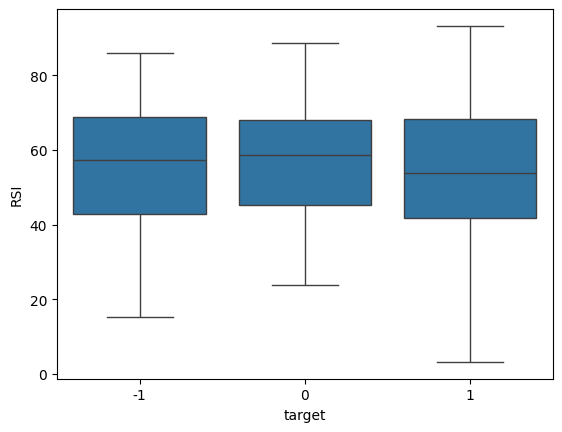

In [33]:
import seaborn as sns

sns.boxplot(x=data["target"], y=data["RSI"])
plt.show()


In [34]:
#chronologie respectée
data = data.sort_index()

#Initialisation des sets
n = len(data)

train = data.iloc[:int(0.6*n)]
valid = data.iloc[int(0.6*n):int(0.8*n)]
test  = data.iloc[int(0.8*n):]


X_train = train.drop(columns=["target"])
y_train = train["target"]

X_valid = valid.drop(columns=["target"])
y_valid = valid["target"]

X_test = test.drop(columns=["target"])
y_test = test["target"]



In [35]:
#normalisation des données
def scale_dataset(X, y, oversample=False, scaler=None):
    if scaler is None:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = scaler.transform(X)

    if oversample:
        ros = RandomOverSampler()
        X_scaled, y = ros.fit_resample(X_scaled, y)

    return X_scaled, y, scaler

In [36]:
X_train_scaled, y_train, scaler = scale_dataset(X_train, y_train)

X_valid_scaled, y_valid, _ = scale_dataset(X_valid, y_valid, scaler=scaler)

X_test_scaled, y_test, _ = scale_dataset(X_test, y_test, scaler=scaler)


In [37]:
print(X_train_scaled.shape, y_train.shape)
print(X_valid_scaled.shape, y_valid.shape)
print(X_test_scaled.shape, y_test.shape)


(532, 24) (532,)
(177, 24) (177,)
(178, 24) (178,)


In [38]:
from sklearn.metrics import confusion_matrix
knn_model = KNeighborsClassifier(n_neighbors=7 , weights="distance")

knn_model.fit(X_train_scaled, y_train)

y_pred = knn_model.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[13  0  0]
 [48  0  2]
 [15  3 97]]
              precision    recall  f1-score   support

          -1       0.17      1.00      0.29        13
           0       0.00      0.00      0.00        50
           1       0.98      0.84      0.91       115

    accuracy                           0.62       178
   macro avg       0.38      0.61      0.40       178
weighted avg       0.65      0.62      0.61       178



In [39]:
data["target"].value_counts()
data["target"].value_counts(normalize=True)


target
 1    0.611048
 0    0.234498
-1    0.154453
Name: proportion, dtype: float64

In [40]:
baseline = data["target"].value_counts(normalize=True).max()
print("Baseline (majority class):", baseline)


Baseline (majority class): 0.6110484780157835


In [41]:
#On laisse tomber knn car il n'est pas du tout accruate(49)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

lr = LogisticRegression(
    max_iter=3000,
    class_weight="balanced"
)

lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[13  0  0]
 [48  1  1]
 [57 54  4]]
              precision    recall  f1-score   support

          -1       0.11      1.00      0.20        13
           0       0.02      0.02      0.02        50
           1       0.80      0.03      0.07       115

    accuracy                           0.10       178
   macro avg       0.31      0.35      0.09       178
weighted avg       0.53      0.10      0.06       178



In [42]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

print(np.isnan(X_train).sum().sum())  # doit être 0


(532, 24) (532,)
(177, 24) (177,)
(178, 24) (178,)
0


In [43]:
print("future_return dans X_train ?", "future_return" in X_train.columns)
print("target dans X_train ?", "target" in X_train.columns)


future_return dans X_train ? False
target dans X_train ? False


In [44]:
y_train_shuffled = y_train.sample(frac=1, random_state=42).values
lr.fit(X_train_scaled, y_train_shuffled)
print("Score avec y mélangé:", lr.score(X_test_scaled, y_test))

Score avec y mélangé: 0.43820224719101125


In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

# Cellule 8 — Entraînement RandomForest
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
# Cellule 9 — Prédiction + métriques
y_pred = rf.predict(X_test)

print("Accuracy:", rf.score(X_test, y_test))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nReport:\n", classification_report(y_test, y_pred, digits=3))


Accuracy: 0.29775280898876405
Balanced accuracy: 0.4492753623188406

Confusion matrix:
 [[13  0  0]
 [50  0  0]
 [28 47 40]]

Report:
               precision    recall  f1-score   support

          -1      0.143     1.000     0.250        13
           0      0.000     0.000     0.000        50
           1      1.000     0.348     0.516       115

    accuracy                          0.298       178
   macro avg      0.381     0.449     0.255       178
weighted avg      0.657     0.298     0.352       178



In [46]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=1,  # à ajuster plus tard
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print("Accuracy:", xgb_model.score(X_test, y_test))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nReport:\n", classification_report(y_test, y_pred, digits=3))

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [-1  0  1]

In [ ]:
data["target"].value_counts(normalize=True)


In [ ]:
data["target"].value_counts(normalize=True)
